## Visualizing Convolution features using MNIST Dataset

Used inputs from: 
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py
https://medium.com/@awjuliani/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4#.2snsuxqts

In [1]:
#Load the required libraries
from __future__ import print_function

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

In [3]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

In [4]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)


In [5]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


In [6]:
# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [7]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
saver = tf.train.Saver()

In [8]:
# Initializing the variables
init = tf.initialize_all_variables()

### Save the model whenever we get high train accuarcy. save these checkpoints.

In [9]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    model_acc = []
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            model_acc.append(acc)
            if max(model_acc) == acc:
                saver.save(sess,"mnist_model"+"_"+str(step*batch_size))
        step += 1
    print("Optimization Finished!")
    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                      y: mnist.test.labels[:256],
                                      keep_prob: 1.}))

Iter 1280, Minibatch Loss= 24570.462891, Training Accuracy= 0.20312
Iter 2560, Minibatch Loss= 8705.623047, Training Accuracy= 0.52344
Iter 3840, Minibatch Loss= 6607.849609, Training Accuracy= 0.68750
Iter 5120, Minibatch Loss= 5389.994629, Training Accuracy= 0.71875
Iter 6400, Minibatch Loss= 2755.871826, Training Accuracy= 0.83594
Iter 7680, Minibatch Loss= 6210.232910, Training Accuracy= 0.78125
Iter 8960, Minibatch Loss= 2972.791016, Training Accuracy= 0.82031
Iter 10240, Minibatch Loss= 2563.947754, Training Accuracy= 0.85156
Iter 11520, Minibatch Loss= 2013.088989, Training Accuracy= 0.87500
Iter 12800, Minibatch Loss= 3334.145020, Training Accuracy= 0.75000
Iter 14080, Minibatch Loss= 1337.024414, Training Accuracy= 0.92188
Iter 15360, Minibatch Loss= 1102.354126, Training Accuracy= 0.92969
Iter 16640, Minibatch Loss= 1969.930176, Training Accuracy= 0.91406
Iter 17920, Minibatch Loss= 1515.366211, Training Accuracy= 0.88281
Iter 19200, Minibatch Loss= 1492.204956, Training Accu

### rebuilding the same graph as above but with different names. We can access each layer with its variable name

In [10]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

x1 = tf.reshape(x, shape=[-1, 28, 28, 1])

# Convolution Layer
conv1 = conv2d(x1, weights['wc1'], biases['bc1'])
# Max Pooling (down-sampling)
conv1_m = maxpool2d(conv1, k=2)

# Convolution Layer
conv2 = conv2d(conv1_m, weights['wc2'], biases['bc2'])
# Max Pooling (down-sampling)
conv2_m = maxpool2d(conv2, k=2)

# Fully connected layer
# Reshape conv2 output to fit fully connected layer input
fc1 = tf.reshape(conv2_m, [-1, weights['wd1'].get_shape().as_list()[0]])
fc2 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
fc3 = tf.nn.relu(fc2)
# Apply Dropout
fc4 = tf.nn.dropout(fc3, dropout)
# Output, class prediction
out = tf.add(tf.matmul(fc4, weights['out']), biases['out'])

correct_pred = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.initialize_all_variables()

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

def maps(layername,feed_input,model_name):
    """
    returns feature maps (graphs) of layers 

    Args:
    layername: The required layer need to be visualized. Usually a numpy array
    feed_input: A dictionary of type {x:,y:,keep_prob:} # check with the network characteristics
    model_name: The model name 

    Returns:
    images of each feature in the layers
    """
    init = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess,model_name)
        units = sess.run(layername,feed_dict=feed_input)
        units = np.asarray(units)
        #visualizations 
        tot_features = units.shape[3]
        for i in range(int(tot_features/4)):
            images = units[0,:,:,i*4:(i+1)*4]
            images = np.rollaxis(images,-1)
            fig,ax = plt.subplots(nrows=1,ncols=4,sharex="col",sharey="row",figsize=(20,3))
            for j,img in enumerate(images):
                ax[j].imshow(img,interpolation="nearest", cmap="gray")

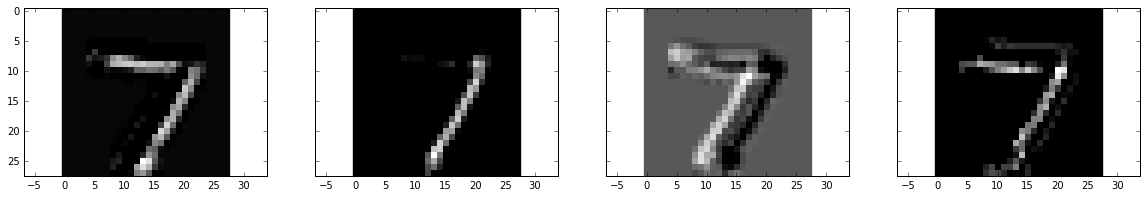

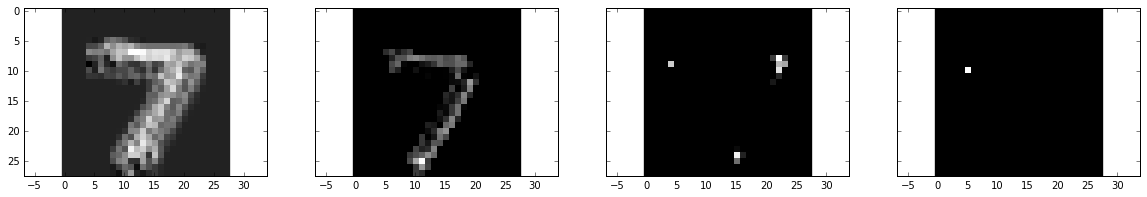

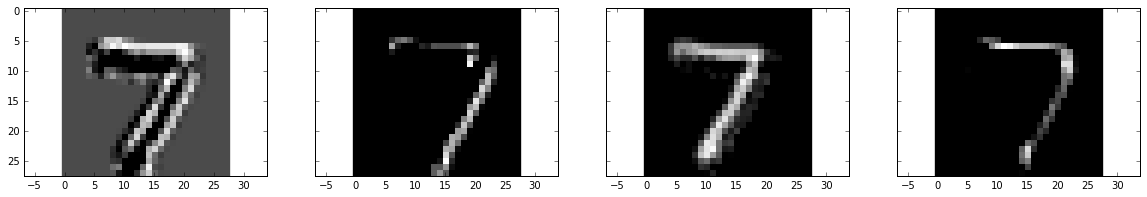

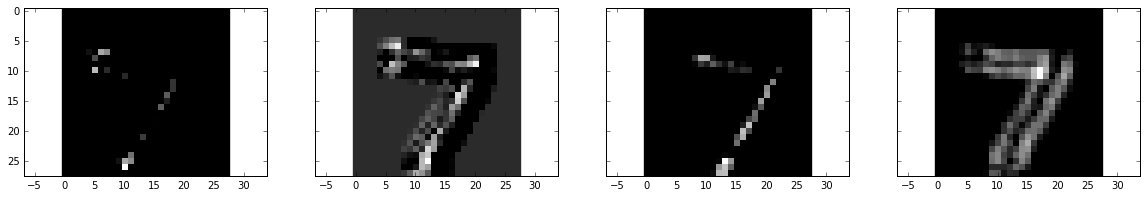

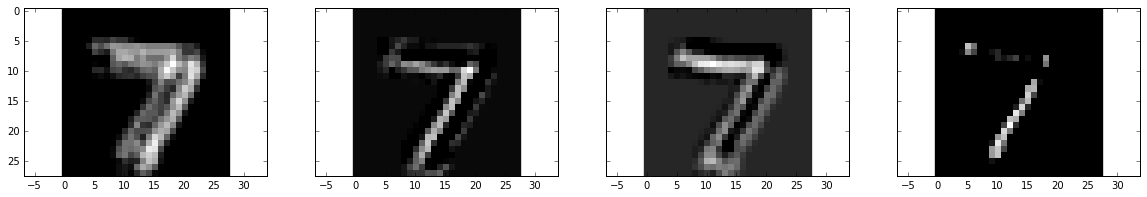

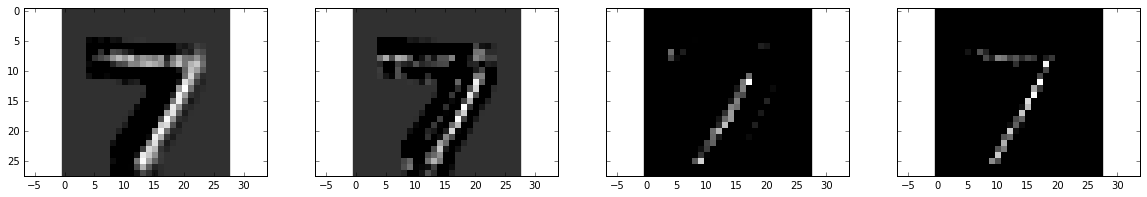

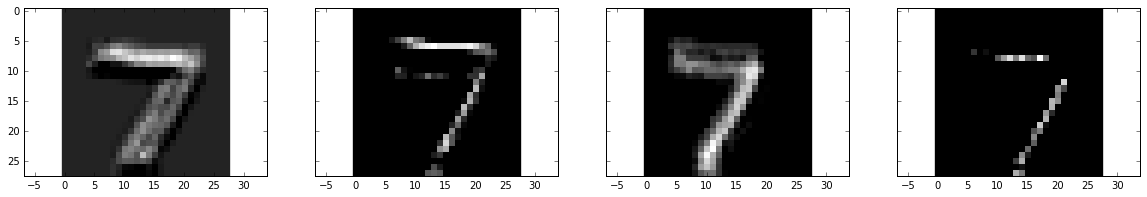

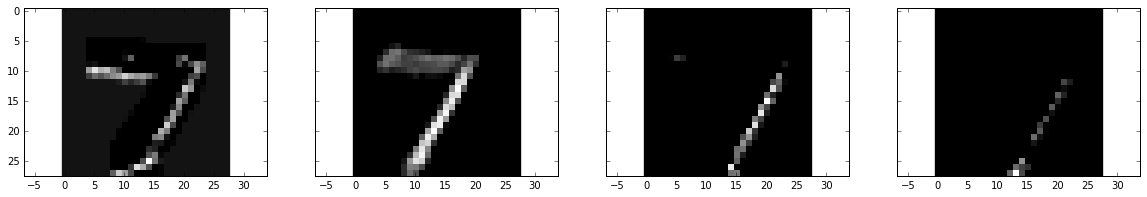

In [15]:
maps(conv1,{x: mnist.test.images[:1],y: mnist.test.labels[:1],keep_prob: 1.},"mnist_model_15360")

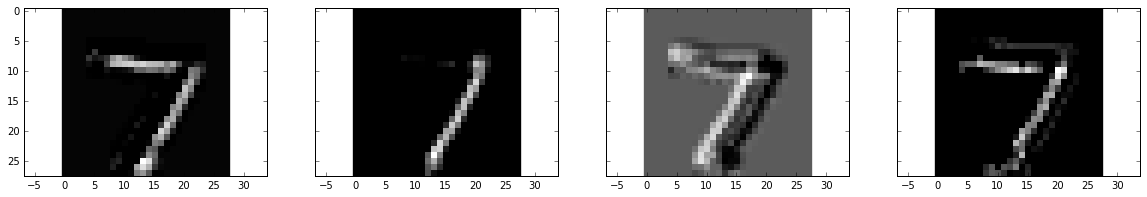

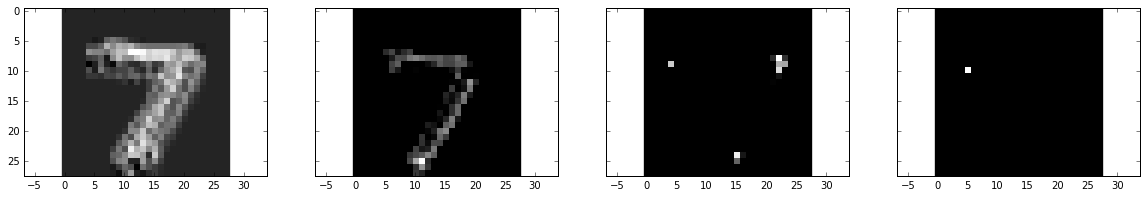

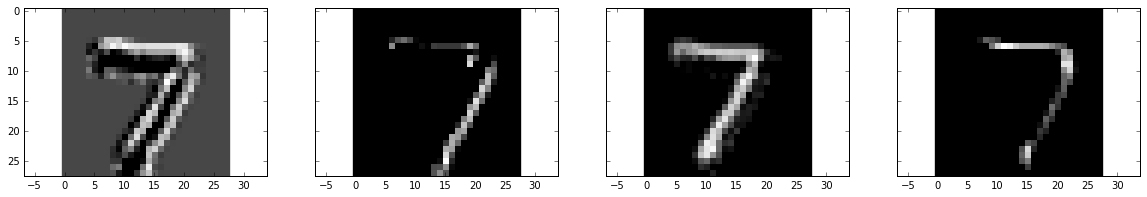

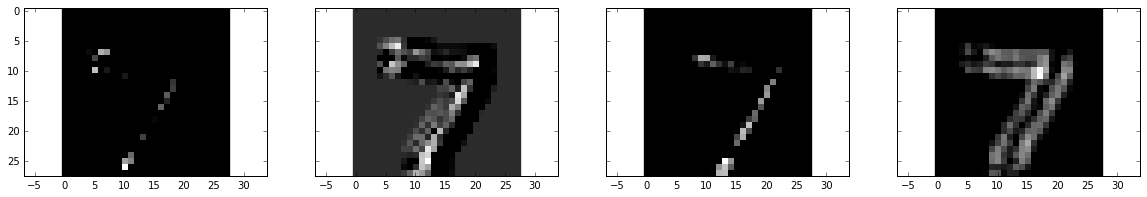

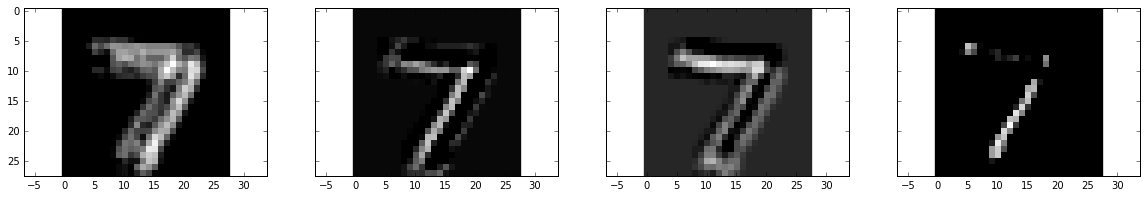

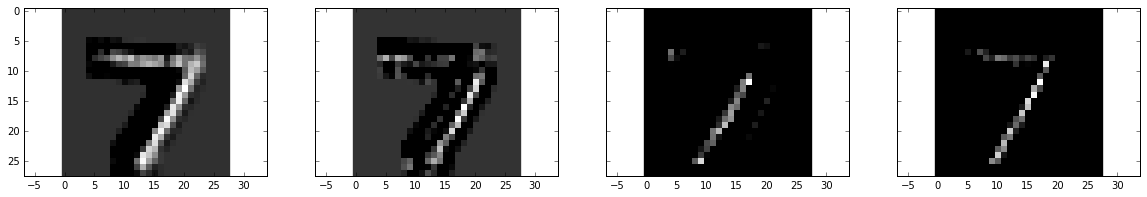

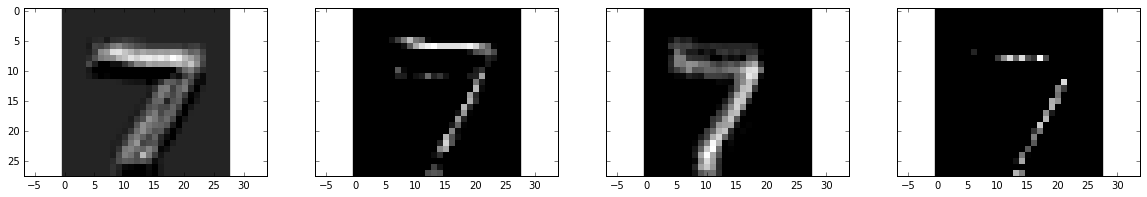

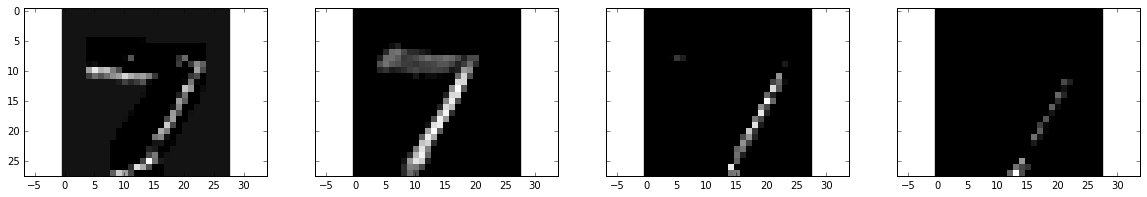

In [16]:
maps(conv1,{x: mnist.test.images[:1],y: mnist.test.labels[:1],keep_prob: 1.},"mnist_model_74240")

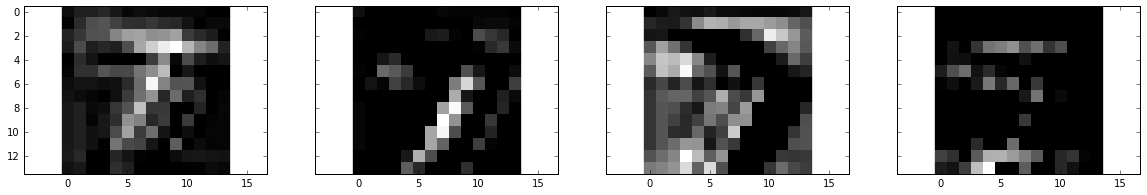

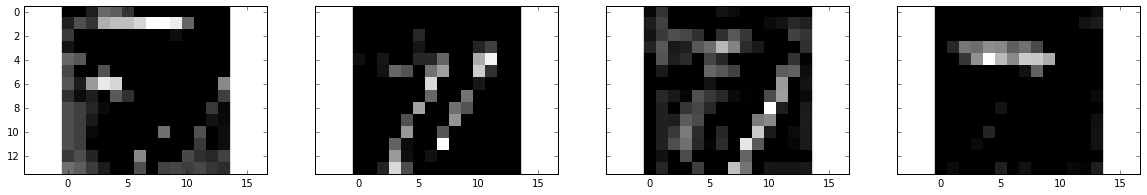

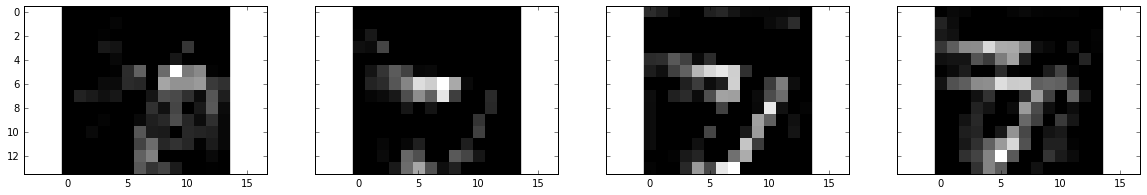

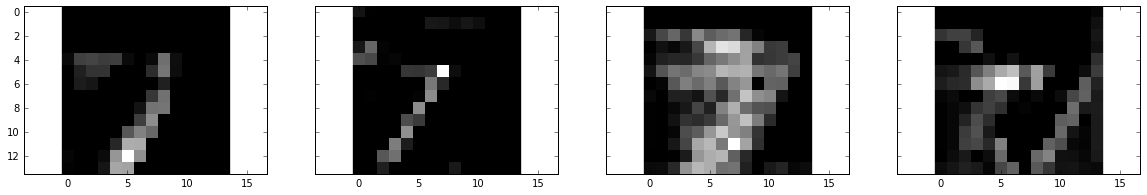

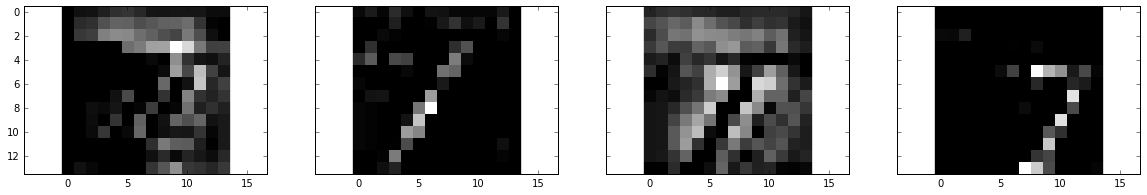

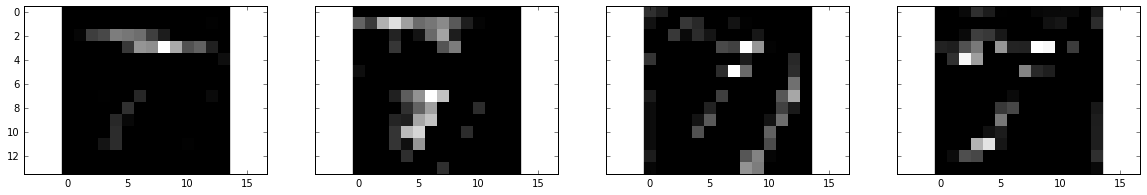

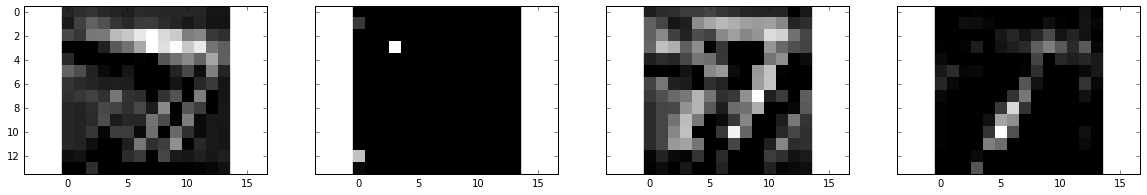

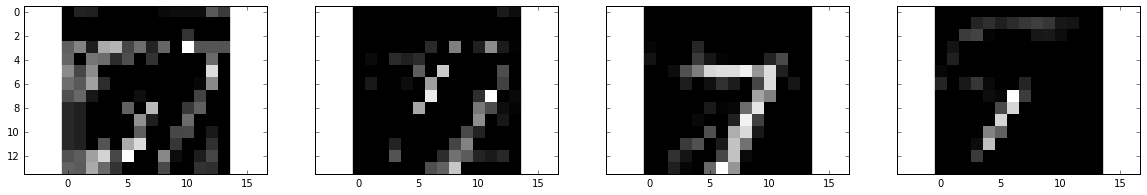

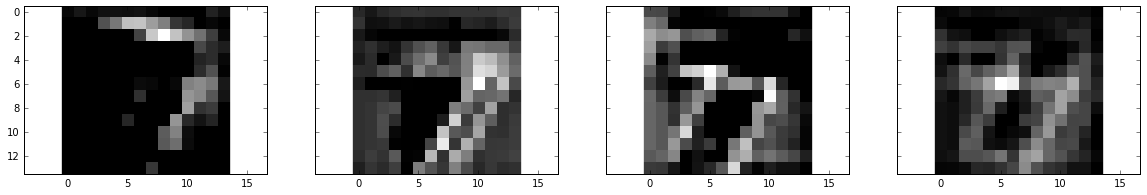

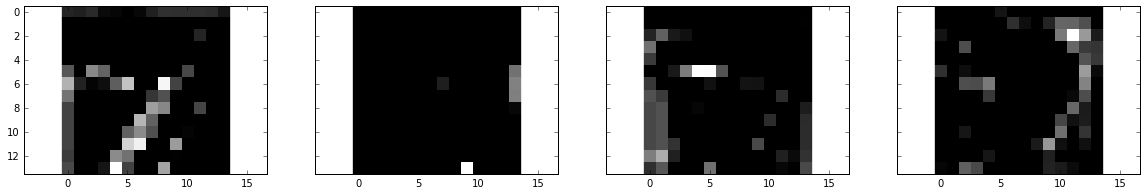

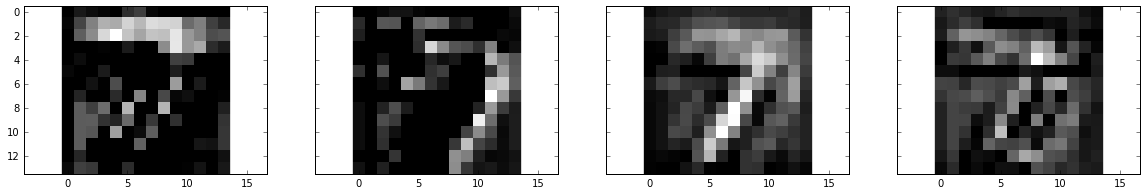

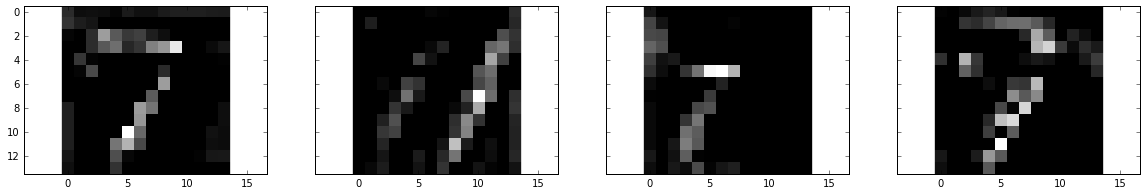

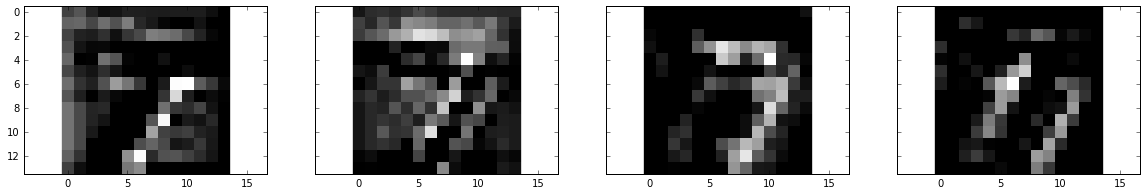

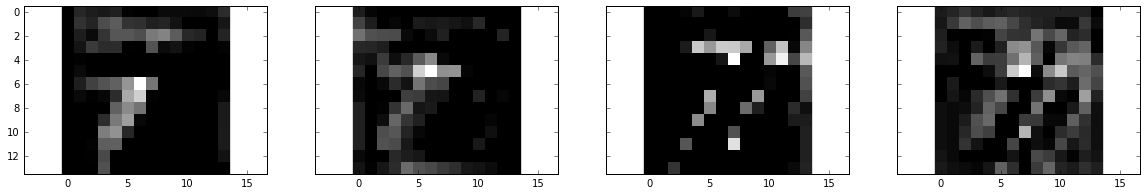

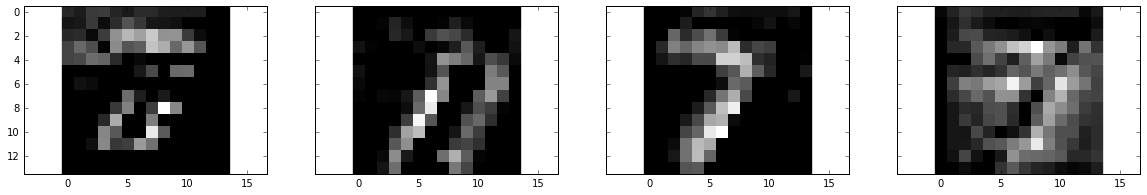

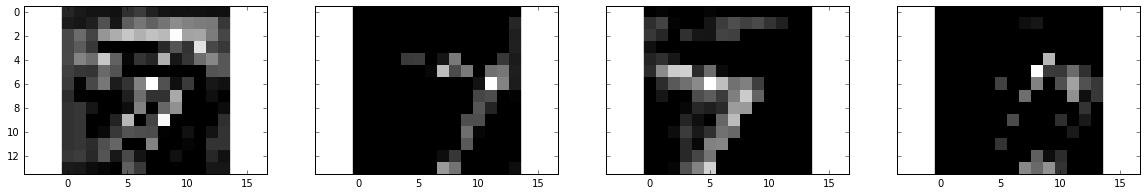

In [17]:
maps(conv2,{x: mnist.test.images[:1],y: mnist.test.labels[:1],keep_prob: 1.},"mnist_model_15360")

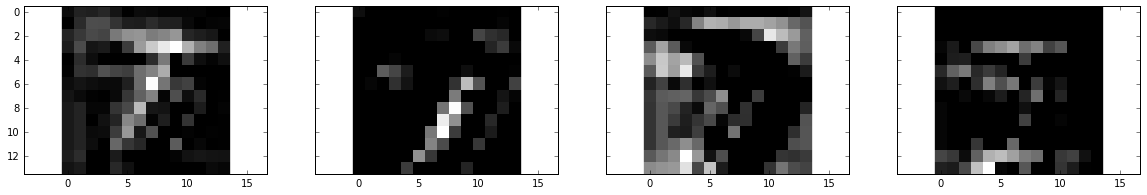

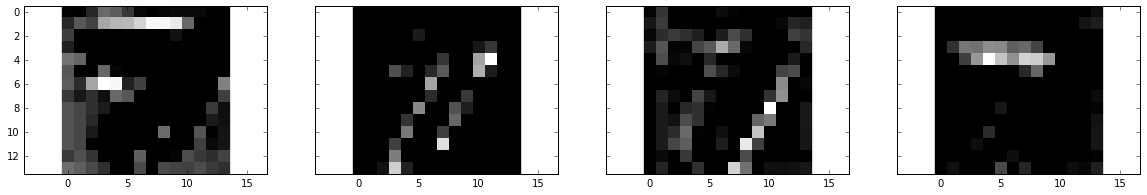

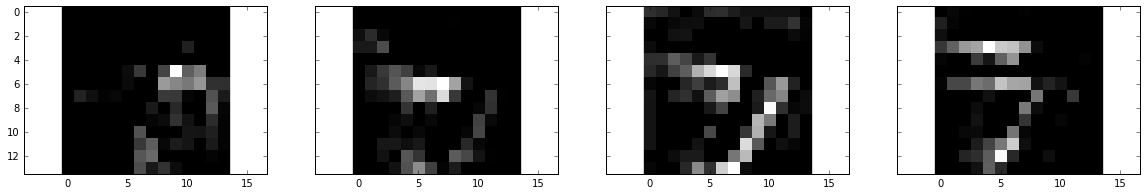

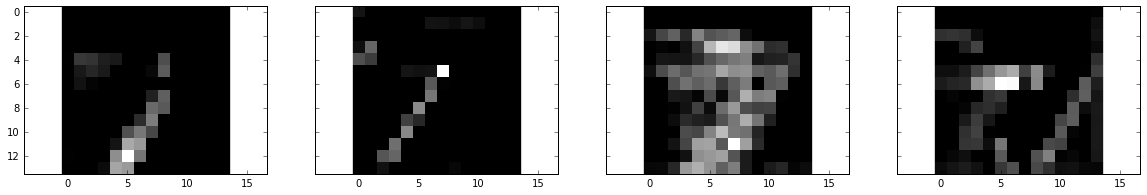

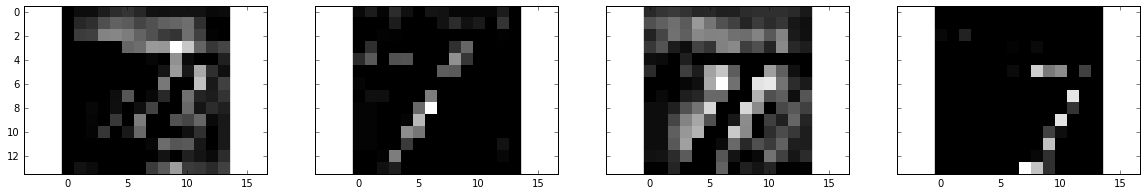

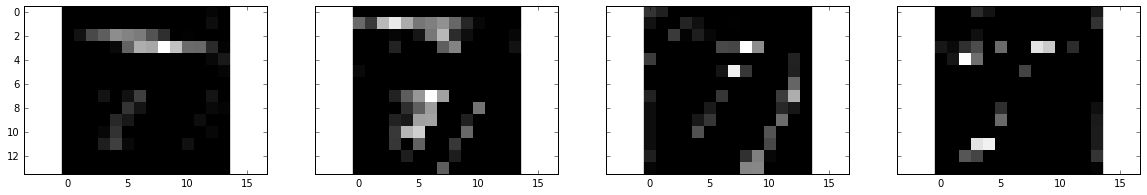

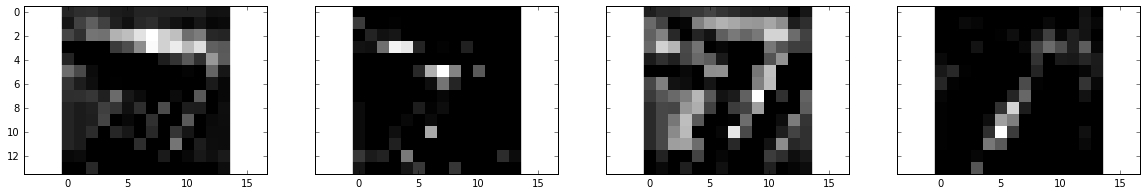

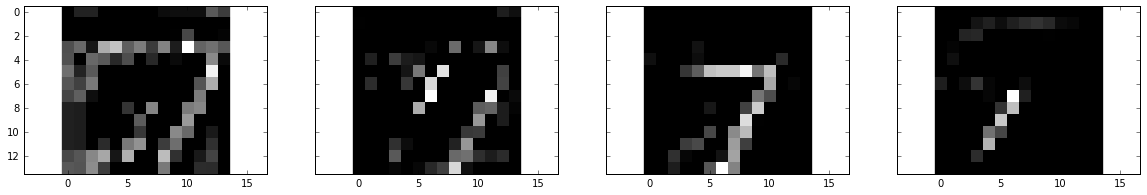

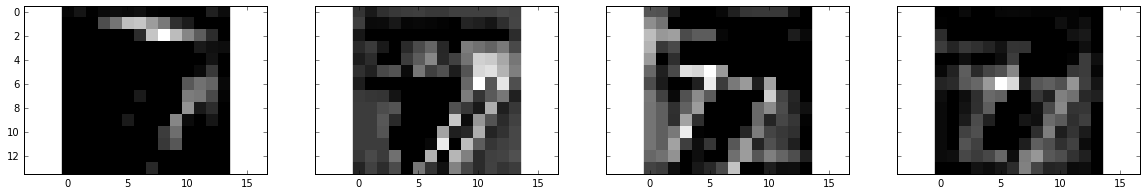

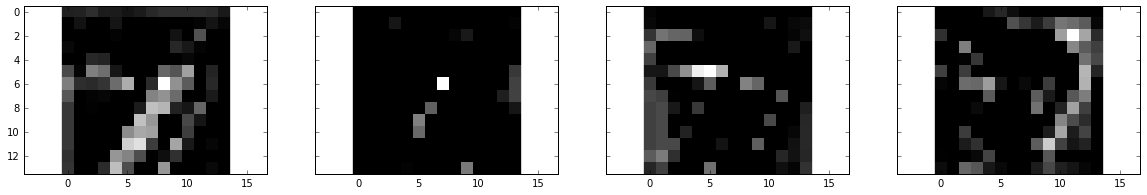

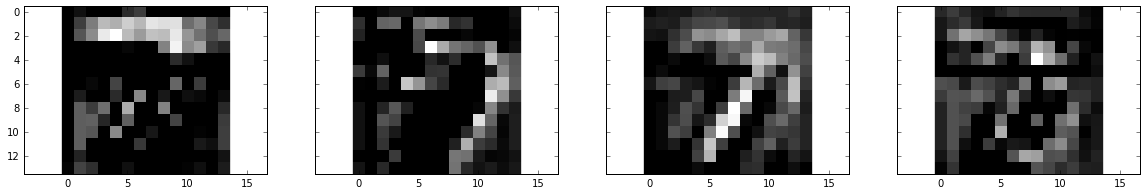

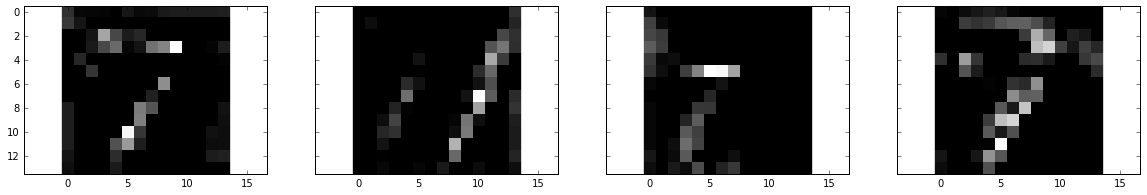

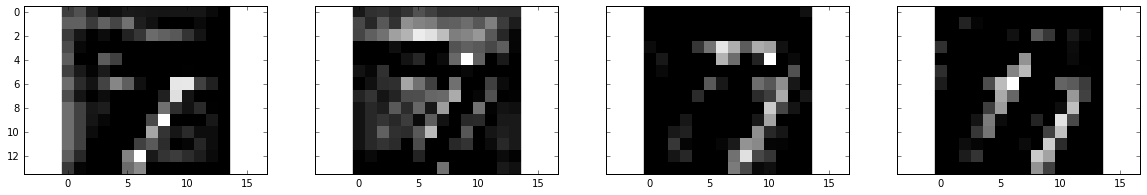

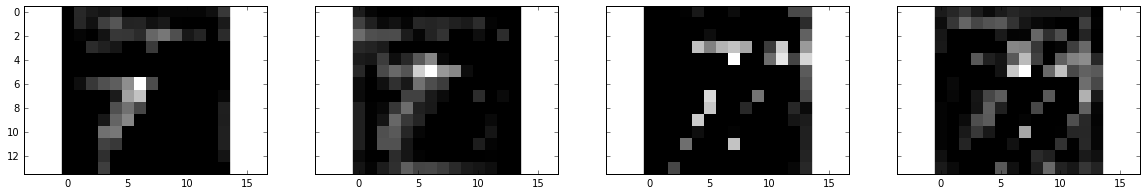

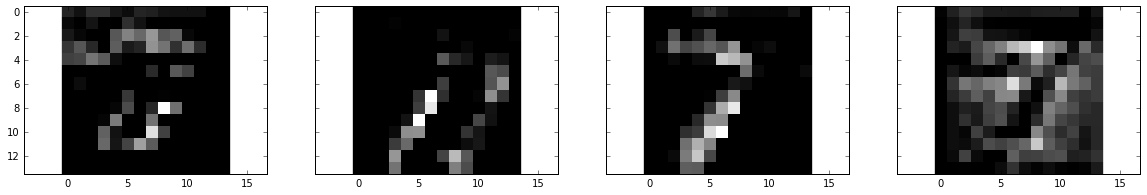

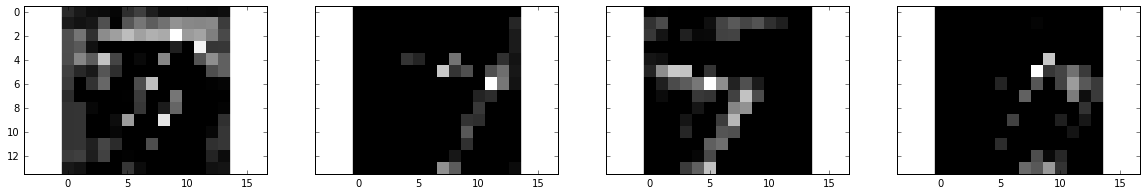

In [18]:
maps(conv2,{x: mnist.test.images[:1],y: mnist.test.labels[:1],keep_prob: 1.},"mnist_model_74240")

## In this way you can visualize all the layers and see how CNN's are learning over time.